In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import tyssue
from tyssue import Sheet, SheetGeometry as geom
from tyssue import Monolayer, config
from tyssue.io import hdf5
from tyssue.draw import sheet_view
from tyssue.dynamics import model_factory, effectors

%matplotlib inline

print("sys", sys.version)
print("tyssue", tyssue.__version__)


sys 3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]
tyssue 0.3.rc1.dev0+0de0045


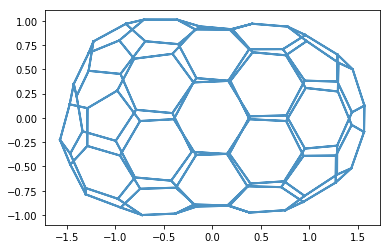

In [2]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet.hf5',
                           data_names=['vert', 'edge', 'face'])

sheet = Sheet('ellipse', dsets,
              config.geometry.cylindrical_sheet())

fig, ax = sheet_view(sheet, mode="quick", coords=list('zx'),
                     edge={"lw":2, "alpha":0.8})

In [3]:
sheet.settings['abc'] = 1., 1., 1.5

In [21]:
active = sheet.vert_df[sheet.vert_df.is_active.astype(bool)].index
sheet.vert_df.loc[active, sheet.coords]

,x,y,z
vert,,,
0,0.797141,-0.270753,-0.959158
1,0.911858,0.027069,-0.630883
2,0.967955,0.379760,-0.892533
3,1.011877,0.006489,-0.363265
4,0.942258,0.392998,-0.130198
5,0.759056,0.714191,-0.350775
6,0.788898,0.710019,-0.691040
7,0.911313,-0.351893,-0.176239
8,0.909174,-0.366549,0.177778


In [4]:
from tyssue import SheetGeometry

class EllipsoidGeometry(SheetGeometry):
    
    @staticmethod
    def update_rho(sheet):
        a, b, c = sheet.settings['abc']
        sheet.vert_df["rho2"] = (  
        (sheet.vert_df.x/a)**2
         + (sheet.vert_df.y/b)**2
         + (sheet.vert_df.z/c)**2)
    
    @classmethod
    def update_all(cls, sheet):
        super().update_all(sheet)
        cls.update_rho(sheet)


class EllipsoidConstraint(effectors.AbstractEffector):
    
    dimensions = None
    magnitude = 'ellipsoid_constraint'
    label = "Ellipsoidal shell sticking constraint"
    element = 'vert'
    specs = {"settings": {"abc": (1., 1., 1.)},
             "vert": {'ellipsoid_constraint': 1.}}
    
    def energy(sheet):
        return sheet.vert_df.eval('ellipsoid_constraint * (rho2 - 1)**2')
    
    def gradient(sheet):
        a, b, c = sheet.settings['abc']
        grad = pd.DataFrame(index=sheet.vert_df.index,
                            columns=['gx', 'gy', 'gz'])
        const = sheet.vert_df.eval(
                f'4*ellipsoid_constraint * (rho2 - 1)').values
        
        for coord, axis in zip(['x', 'y', 'z'], (a, b, c)):
            grad['g'+coord] = const * sheet.vert_df[coord].values / axis**2
    
        return grad, None
            


In [5]:
model = model_factory([
    effectors.LineTension,
    effectors.FaceAreaElasticity,
    EllipsoidConstraint], effectors.FaceAreaElasticity)



In [6]:
sheet.vert_df['ellipsoid_constraint'] = 1
sheet.face_df['prefered_area'] = sheet.face_df.area.mean()

EllipsoidGeometry.update_all(sheet)

In [7]:
model.compute_energy(sheet)

9.747734119192137

In [8]:
from tyssue.draw.plt_draw import plot_forces

/home/guillaume/miniconda3/lib/python3.7/site-packages/tyssue-0.3rc1-py3.7-linux-x86_64.egg/tyssue/dynamics/factory.py:83: UserWarning: setting ucoords in grad computation,please fix your specs
  "setting ucoords in grad computation," "please fix your specs"


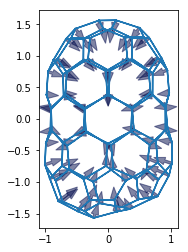

In [9]:
fig, ax = plot_forces(sheet, EllipsoidGeometry,
                      model, list('xz'), scaling=0.11)
ax.autoscale()

In [10]:
from tyssue.solvers.quasistatic import QSSolver
import logging
logger = logging.getLogger('tyssue.topology.sheet_topology')
logger.setLevel('INFO')
import sys

handler = logging.StreamHandler(sys.stdout)
logger.addHandler(handler)

solver = QSSolver(with_collisions=True, with_t1=True, with_t3=True)


In [15]:

res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


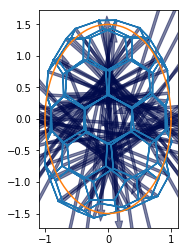

In [16]:
fig, ax = plot_forces(sheet, EllipsoidGeometry,
                      model, list('xz'), scaling=10)
ax.autoscale()
ts = np.linspace(0, 2*np.pi, 100)
a, b, c = sheet.settings['abc']
ax.plot(a*np.cos(ts), c*np.sin(ts))

In [17]:
fig, meshes = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(aspect=0.8, fov=46.0, matrixWorldNeedsUpdate=True, position=(0.0, 1.2246467991…

In [20]:
from tyssue.generation import ellipsoid_sheet
abc = 85, 85, 150
sheet = ellipsoid_sheet(*abc, 77, phase_err=1e-3, pos_err=1e-3)
print(sheet.Nf)

5946


In [21]:
sheet.vert_df['ellipsoid_constraint'] = 200.
sheet.face_df['prefered_area'] = sheet.face_df.area.mean()
sheet.face_df['area_elasticity'] = 1.

sheet.edge_df['line_tension'] = 0.07
EllipsoidGeometry.update_all(sheet)

In [22]:
sheet.settings['threshold_length'] = 1e-3


In [23]:
res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

performing 2 T1
removed 3 of 11889 vertices 
face 1927 is now dead 
removed 3 of 11887 vertices 
face 1972 is now dead 
removed 3 of 11885 vertices 
face 3897 is now dead 
removed 3 of 11883 vertices 
face 5046 is now dead 


error: failed in converting 7th argument `g' of _lbfgsb.setulb to C/Fortran array

In [24]:
import ipyvolume as ipv

In [25]:
ipv.clear()
fig, meshes = sheet_view(sheet, mode='3D', face={'visible':True, 'color': sheet.face_df.area})
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [22]:
res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [27]:
sheet.edge_df.length.min()

0.06241927129657546

In [31]:
sheet.settings['threshold_length'] = 3e-1


In [34]:
res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

performing 2 T1
performing 2 T1
performing 8 T1
performing 4 T1
performing 12 T1
performing 4 T1
performing 4 T1
performing 4 T1
performing 4 T1
performing 4 T1
performing 4 T1
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [39]:
from tyssue.collisions import self_intersections
intersecting_edges = self_intersections(sheet)

In [40]:
intersecting_edges

array([], shape=(0, 2), dtype=int64)

In [26]:
from scipy.spatial import cKDTree



In [38]:
tree = cKDTree(sheet.face_df[sheet.coords].values)

In [43]:
sheet.edge_df.length.mean()

3.332612722670618

In [67]:
tree.data

array([[-6.03808040e+01, -1.72314892e+01,  1.00956779e+02],
       [-4.13765694e+01,  6.40259889e-02,  1.30905595e+02],
       [-4.39251673e+01,  7.55245003e-02,  1.28291998e+02],
       ...,
       [ 5.97886470e+01,  5.96137975e+01, -1.64381168e+01],
       [ 5.55288419e+01,  6.40027091e+01, -1.04184414e+01],
       [ 5.55004921e+01,  6.38022652e+01, -1.40632805e+01]])

In [61]:
pairs = np.array([[a, b] for a, b in tree.query_pairs(7)])

In [57]:
%pdb

Automatic pdb calling has been turned OFF


In [64]:
pairs = pd.DataFrame(pairs, columns=['A', 'B']).sort_values('A')

In [86]:
dist, indices = tree.query(tree.data, range(2, 8), distance_upper_bound=20, eps=1e-1)

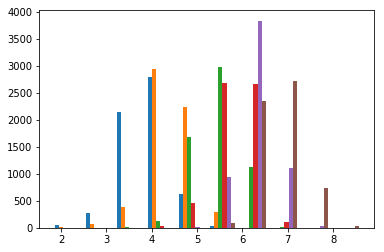

In [78]:
h = plt.hist(dist)

In [79]:
dist.shape

(5946, 6)

In [87]:
dist

array([[3.78593865, 4.23698193, 5.49474954, 5.54844279, 5.72826983,
        7.2442121 ],
       [3.65053054, 3.98707297, 5.77577856, 6.26688517, 6.38187773,
        6.76226011],
       [3.65053054, 4.04488332, 5.72960191, 6.4249375 , 6.69507237,
        6.80750181],
       ...,
       [3.69822452, 4.43488308, 6.22284621, 6.29726632, 6.37795262,
        6.44758724],
       [3.65045655, 4.25926058, 6.38790784, 6.39229571, 6.41676463,
        6.43892341],
       [3.65045655, 3.8909928 , 6.37014095, 6.39981484, 6.41285419,
        6.44758724]])

In [82]:
tree.data.shape

(5946, 3)

In [88]:
a = np.arange(10000)
b = np.random.random(10000)

%timeit (a + b).sum()
%timeit (a.sum() + b.sum())

38.1 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
39.1 µs ± 635 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [93]:
abc


(85, 85, 150)

In [234]:
from dataclasses import dataclass
from scipy.optimize import check_grad, minimize
from tyssue.generation.shapes import get_ellipsoid_centers
import xarray as xr

@dataclass
class ConstrainedPoints:
    '''Class for keeping track of an item in inventory.'''
    abc: tuple
    lagrange: float = 10.0
    eq_dist: float = None
    
    def update(self, points):
        
        a, b, c = self.abc
        self.points = points
        self.Np = points.shape[0]
        if self.eq_dist is None:
            self.eq_dist = 2 * c / np.sqrt(self.Np)

        self.rho2 = ((points / np.array([[a, b, c]]))**2).sum(axis=1) - 1
        self.tree = cKDTree(points)
        self.distances, self.indices = self.tree.query(
            self.tree.data, range(2, 8),
            eps=1e-1, n_jobs=-1)

    def energy(self):
        ellipsoid = 0# (self.lagrange * self.rho2**2)
        springs =(0.5*(self.distances - self.eq_dist)**2).sum(axis=1)
        return (springs + ellipsoid).sum()
    
    def gradient(self):
        edge_grad = (
            (self.points[self.indices] - self.points[:, None, :])
            * (1 - self.eq_dist / self.distances[:, :, None])
        )
        
        grad_elastic = edge_grad.sum(axis=1)
        trgt_grad = -xr.DataArray(
            edge_grad.reshape((-1, 3)),
            coords={'index':self.indices.ravel(),
            'pos': ['x', 'y', 'z']},
            dims=['index', 'pos']).groupby('index').sum(axis=0).values
        grad_elastic = grad_elastic# + trgt_grad
        #a, b, c = self.abc
        #grad_ellipsis = 4*self.lagrange * self.rho2[:, None] * self.points /(np.array([[a, b, c]]))**2
        return grad_elastic # + grad_ellipsis
        
        
def cost_func(flat_pos, cp):
    cp.update(flat_pos.reshape((-1, 3)))
    return cp.energy()

def grad_func(flat_pos, cp):
    return cp.gradient().ravel()


In [235]:
from tyssue.generation import hexa_grid2d

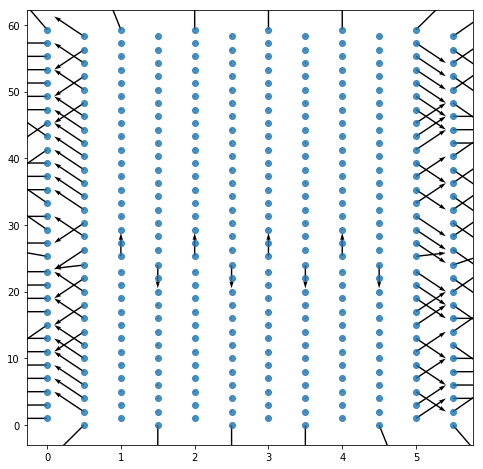

In [236]:
abc = (85, 85, 150)
points = get_ellipsoid_centers(*abc, 11, pos_err=1e-1)[['x', 'y', 'z']].values
points = np.zeros((360, 3))
points[:, :2] = hexa_grid2d(6, 60, 1, 1, noise=0)
points[150:, 1] += 0.3



cp = ConstrainedPoints(abc, lagrange=0, eq_dist=1.)
cp.update(points)

fig, ax = plt.subplots()
ax.plot(points[:, 0], points[:, 1], 'o', alpha=0.8)
ax.quiver(*cp.points.T[:2], *-cp.gradient().T[:2], scale=10)
fig.set_size_inches(8, 8)

In [171]:
cp.distances

array([[0.76376262, 0.76376262, 1.        , 1.15470054, 1.52752523,
        1.60727513],
       [0.76376262, 0.76376262, 1.        , 1.        , 1.15470054,
        1.52752523],
       [0.76376262, 0.76376262, 1.        , 1.        , 1.15470054,
        1.52752523],
       [0.76376262, 0.76376262, 1.        , 1.        , 1.15470054,
        1.52752523],
       [0.76376262, 0.76376262, 1.        , 1.        , 1.15470054,
        1.52752523],
       [0.76376262, 1.        , 1.15470054, 1.52752523, 1.60727513,
        1.80277564],
       [0.76376262, 0.76376262, 1.        , 1.15470054, 1.52752523,
        1.60727513],
       [0.76376262, 0.76376262, 0.76376262, 0.76376262, 1.        ,
        1.        ],
       [0.76376262, 0.76376262, 0.76376262, 0.76376262, 1.        ,
        1.        ],
       [0.76376262, 0.76376262, 0.76376262, 0.76376262, 1.        ,
        1.        ],
       [0.76376262, 0.76376262, 0.76376262, 0.76376262, 1.        ,
        1.        ],
       [0.76376262, 0

In [158]:
cp.eq_dist

1.0

In [237]:
(check_grad(cost_func, grad_func, points.ravel(), cp, epsilon=1e-3)
    / (cp.Np*np.linalg.norm(cp.gradient(), axis=1).mean()))


0.2214068372659012

In [222]:
res = minimize(cost_func, points.ravel(), args=(cp,), jac=grad_func)


/home/guillaume/miniconda3/lib/python3.7/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [223]:
res['message']

'Desired error not necessarily achieved due to precision loss.'

/home/guillaume/miniconda3/lib/python3.7/site-packages/xarray/core/groupby.py:601: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


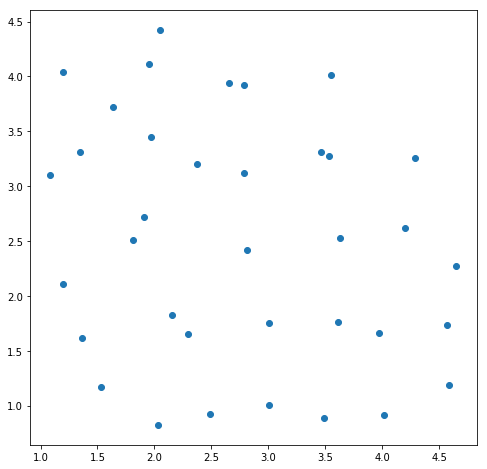

In [224]:
fig, ax = plt.subplots()
ax.plot(cp.points[:, 0], cp.points[:, 1], 'o')
ax.quiver(*cp.points.T[:2], *-cp.gradient().T[:2], scale=5)

fig.set_size_inches(8, 8)

In [349]:
from tyssue import BulkGeometry, Epithelium
from tyssue.generation import from_3d_voronoi, single_cell
from scipy.spatial import Voronoi


def ellipsoid_sheet(a, b, c, n_zs, centers=None, **kwargs):
    """Creates an ellipsoidal apical mesh.

    Parameters
    ----------
    a, b, c : floats
       Size of the ellipsoid half axes in
       the x, y, and z directions, respectively
    n_zs : int
       The (approximate) number of faces along the z axis.

    kwargs are passed to `get_ellipsoid_centers`

    Returns
    -------
    eptm : a :class:`Epithelium` object

    The mesh returned is an `Epithelium` and not a simpler `Sheet`
    so that a unique cell data can hold information on the
    whole volume of the ellipsoid.

    """
    if centers is None:
        centers = get_ellipsoid_centers(a, b, c, n_zs, **kwargs)

    centers = centers.append(
        pd.Series({"x": 0, "y": 0, "z": 0, "theta": 0, "phi": 0}), ignore_index=True
    )

    centers["x"] /= a
    centers["y"] /= b
    centers["z"] /= c

    vor3d = Voronoi(centers[list("xyz")].values)
    vor3d.close()
    dsets = from_3d_voronoi(vor3d)
    veptm = Epithelium("v", dsets, config.geometry.bulk_spec())
    eptm = single_cell(veptm, centers.shape[0] - 1)

    eptm.vert_df["rho"] = np.linalg.norm(eptm.vert_df[eptm.coords], axis=1)
    eptm.vert_df["theta"] = np.arcsin(eptm.vert_df.eval("z/rho"))
    eptm.vert_df["phi"] = np.arctan2(eptm.vert_df["y"], eptm.vert_df["x"])

    eptm.vert_df["x"] = a * (
        np.cos(eptm.vert_df["theta"]) * np.cos(eptm.vert_df["phi"])
    )
    eptm.vert_df["y"] = b * (
        np.cos(eptm.vert_df["theta"]) * np.sin(eptm.vert_df["phi"])
    )
    eptm.vert_df["z"] = c * np.sin(eptm.vert_df["theta"])
    eptm.settings["abc"] = [a, b, c]
    BulkGeometry.update_all(eptm)
    return eptm


new = pd.DataFrame(res['x'].reshape((-1, 3)), columns=['x', 'y', 'z'])

sheet = ellipsoid_sheet(*abc, n_zs=5, centers=new)

ipv.clear()
fig, mesh = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [199]:
points.shape

(242, 3)